In [159]:
from typing import TypedDict, Annotated, List, Dict, Optional

import operator


class FinancialData(TypedDict):
    ratios: Dict
    earnings_trend: str
class SentimentData(TypedDict):
    score: float
    summary: str
class InvestmentState(TypedDict):
    ticker: str
    question:str
    answer: str       
    messages: Annotated[List[str],operator.add]
    fundamental_data: Optional[FinancialData]
    Sentiment_data: Optional[SentimentData]
    Context_data: Annotated[List[str],operator.add]
   

    current_step: str
    is_debated: bool


In [160]:
import yfinance as yf

In [161]:
import os
from dotenv import load_dotenv

# 1. Load the variables from .env into the environment
load_dotenv()

# 2. Retrieve the key
api_key = os.getenv("OPEN_API_KEY")

if not api_key:
    raise ValueError("API Key not found. Please set it in the .env file.")

print("Key loaded successfully!")

Key loaded successfully!


In [162]:
###{'pe_ratio': 33.4488, 'debt_to_equity': 102.63, 'revenue_growth': 0.157###

In [163]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

In [ ]:
from langchain_community.tools import YahooFinanceNewsTool
from langchain.tools import tool
import yfinance as yf

@tool

def get_fundamental_metrics(ticker: str):
    """Fetches P/E, Debt-to-Equity, and Revenue Growth for a given ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    
    return {
        "pe_ratio": info.get("trailingPE"),
        "debt_to_equity": info.get("debtToEquity"),
        "revenue_growth": info.get("revenueGrowth"),
    }

tools = [get_fundamental_metrics]

from langchain_openai import ChatOpenAI

# Initialize the LLM with tool binding
llm = ChatOpenAI(model="gpt-4o",api_key=api_key).bind_tools(tools)
def fundamental_analyst_node(state :InvestmentState):
    ticker= state['ticker']

    prompt=f""" 
You are an expert Fundamental Analyst. Analyze the financial metrics for {ticker}

1. Use the 'get_fundamental_metrics' tool to retrieve current data.

2. Assess the financial health based on P/E and Debt/Equity.

3. Return a concise, structure analysis.


 """

    response= llm.invoke([("system", prompt),("human" , f"Analyze {ticker}")])

    if response.tool_calls:

        tool_name = response.tool_calls[0]["name"]
        tool_args = response.tool_calls[0]["args"]
    
    if tool_name == "get_fundamental_metrics":
        tool_result = get_fundamental_metrics.invoke(tool_args)

        print(f"tools result {tool_result}")

        messages = [
            SystemMessage(content=prompt),
            HumanMessage(content=f"Analyze {ticker}"),
            response, # Pass the AIMessage object directly
            ToolMessage(
                tool_call_id=response.tool_calls[0]["id"],
                content=str(tool_result)
            )
        ]
        
        final_response = llm.invoke(messages)

        state['fundamental_data']=final_response.content

    else:

        state['fundamental_data']=response.content

    return state

In [ ]:
def router(state: InvestmentState):

    fund = state.get("fundamental_data")
    sent = state.get("Sentiment_data")
    context=state.get("Context_data")
    
    if fund and sent and context:
        return {"current_step": "synthesis"}
    elif not fund:
        return {"current_step": "fundamental_analyst"}
    elif not sent:
        return {"current_step": "sentiment_analyst"}
    elif not context:
            return {"current_step": "retrieve"}
    else:
        return {"current_step": "synthesis"}
        

In [ ]:
def route_after_supervisor(state: InvestmentState):

    return state["current_step"]

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

def sentiment_analyst_node(state: InvestmentState):
    ticker = state["ticker"]
    
    results = search_tool.invoke(f"market sentiment and news for {ticker}")

    state['Sentiment_data']=results

    return state

In [ ]:
from earningscall import get_company
from langchain_core.documents import Document 
from langchain_text_splitters import RecursiveCharacterTextSplitter

def retrieve_earningcall(ticker='aapl'):

    company = get_company(ticker)  


    transcript1 = company.get_transcript(year=2025, quarter=3, level=4)

    docs = [
        Document(
            page_content=transcript1.prepared_remarks,
            metadata={"section": "prepared_remarks"}
        ),
        Document(
            page_content=transcript1.text,
            metadata={"section": "discussion"}
        )
    ]

    return docs

def chunk_docs(docs):
    splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=200
)

    chunked_docs = splitter.split_documents(docs)


    return chunked_docs

In [169]:
def filter_docs(docs):

    docs_filterd=[]
    for chunk in docs:
        docs_filterd.append(chunk.page_content)

    return docs_filterd


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

def retrieve_chunks(chunks, query, top_k=5):
        model = SentenceTransformer("all-MiniLM-L6-v2")
        chunk_embeddings =model.encode(chunks, convert_to_numpy=True)
        query_embedding = model.encode([query], convert_to_numpy=True)

        similarities = cosine_similarity(query_embedding, chunk_embeddings)[0]
        
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        return [chunks[i] for i in top_indices]


def earnings_rag_runtime(filter_docs,query,top_k):
    top_chunks = retrieve_chunks(filter_docs, query, top_k)
    return top_chunks

def retrieve_node(state: InvestmentState):
    print("---RETRIEVING CONTEXT---")
    
    ticker=state.get('ticker')
    question=state.get('question')

    docs=retrieve_earningcall(ticker)
    docs=chunk_docs(docs)
    filtered=filter_docs(docs)
    
    best_chunks = earnings_rag_runtime(filtered, question,top_k=3)

    state["Context_data"]=[best_chunks]
    return state

In [171]:
def synthesis_node(state: InvestmentState):
    """
    Acts as the 'Chief Investment Officer'. 
    Reads the Fundamental and Sentiment data and produces a final verdict.
    """
    # 1. Access both data sources
    fund_data = state.get("fundamental_data", {})
    sent_data = state.get("Sentiment_data", {})
    question=state.get("question",{})
    context=state.get("Context_data",{})

    print(f"context_data: {context}")


    print(f" fundamental data {fund_data} sentimental_data={sent_data}")
    # 2. Instruct the LLM to synthesize
    prompt = f"""
    You are the Chief Investment Officer. Synthesize this data for {state['ticker']}:
    Fundamental: {fund_data}
    Sentiment: {sent_data}

    Also answer user's question: {question} considering the sec statements and filings {context}
    
    Produce a final Buy/Sell/Hold make it BOLD and underlined and in the next line give recommendation with a clear rationale also based on the context.

    
    """
    
    # 3. Generate report
    response = llm.invoke(prompt)

    #print(f"final analyst data : {response.content}")
    
    state['messages']=[response.content]

    return state

In [172]:
from langgraph.graph import END, StateGraph

graph= StateGraph(InvestmentState)
graph.set_entry_point("supervisor")
graph.add_node("fundamental_analyst",fundamental_analyst_node)
graph.add_node("sentiment_analyst",sentiment_analyst_node)
graph.add_node("retrieve",retrieve_node)
graph.add_node("supervisor",router)
graph.add_node("synthesis",synthesis_node)


graph.add_conditional_edges(
    "supervisor",
    route_after_supervisor, # This reads the state update from the router node
    {
        "fundamental_analyst": "fundamental_analyst",
        "sentiment_analyst": "sentiment_analyst",
        "retrieve":"retrieve",
        "synthesis": "synthesis",
        "__end__": END
    })
graph.add_edge("fundamental_analyst", "supervisor")
graph.add_edge("sentiment_analyst", "supervisor")
graph.add_edge("retrieve", "supervisor")
graph.add_edge("synthesis", END)


app= graph.compile()

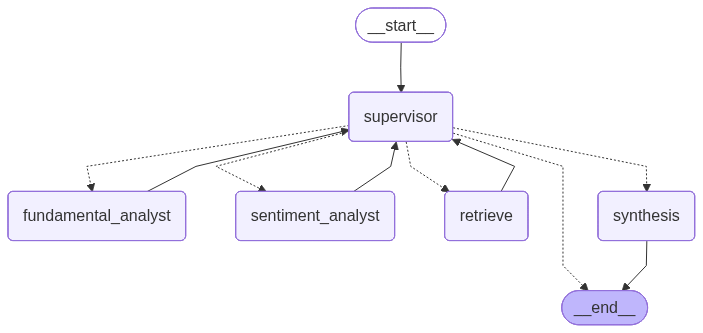

In [ ]:
from IPython.display import Image, display
Image(app.get_graph().draw_mermaid_png())

In [174]:
# Invoke the graph
final_state = app.invoke(
    {"ticker": "AAPL", "current_step": "supervisor","question": "how is the stock performing should i buy it"}, 
    config={"recursion_limit": 10}
)
# Print the results
print("--- Final State ---")
from IPython.display import display, Markdown



tools result {'pe_ratio': 33.440506, 'debt_to_equity': 102.63, 'revenue_growth': 0.157}
---RETRIEVING CONTEXT---


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 225.12it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


context_data: [["of Apple Silicon is playing a very key role. And so it was an incredible quarter. In terms of if you're wondering about pull forward, We would estimate the pull forward of demand into April specifically to be about one point of the 10 points in terms of people buying because of discussions about tariffs. All right. Thank you, Mike. Thank you, Tim. Thank you, Kevin. Thanks, Mike. Operator, can we have the next question, please? Our next question is from Eric Woodring with Morgan Stanley. Please go ahead. Good afternoon, guys. Thank you very much for taking my questions. I have two as well. Maybe starting with you, you know, shortly after March quarter earnings, there were some reports about surges on Safari declining in April for the first time, I think, in over two decades. So touching by your 13% services growth this quarter, it doesn't seem to indicate that April trends necessarily played out through the remainder of the June quarter. And so I'm really just looking f

In [176]:
display(Markdown(final_state.get("messages")[-1]))

### AAPL Financial and Sentiment Analysis

#### Financial Metrics
1. **P/E Ratio**: 33.44
   - **Analysis**: Investors show strong confidence in AAPL with willingness to pay $33.44 per $1 of earnings, highlighting strong growth prospects but also the potential for overvaluation.

2. **Debt-to-Equity Ratio**: 102.63%
   - **Analysis**: High reliance on debt financing presents increased financial risk, especially amid volatile market conditions.

3. **Revenue Growth**: 15.7%
   - **Analysis**: Reflects robust business expansion and supports the high P/E ratio, though monitoring debt levels is crucial.

#### Market Sentiment
- **Regulatory Challenges**: Facing scrutiny from a Department of Justice antitrust lawsuit that may require opening its iMessage and Apple Pay protocols.
- **Stock Movement**: Recently declined by over 10% due to management changes and AI strategy concerns, rather than fundamental weaknesses.
- **Earnings Outlook**: Upcoming earnings report brings cautious optimism, with strength particularly in AI positioning and continued strong revenue from services.

#### Recent SEC Statements & Filings
- **Performance Indicators**: High levels of customer satisfaction, strong services growth, and significant tariff-related costs impacting the bottom line.
- **Operational Highlights**: Achievements in revenue and product growth despite challenges, supported by a substantial active device base.

### Final Recommendation
**__HOLD__**

**Rationale**: While Apple's financial fundamentals remain strong with impressive growth and profitability metrics, elevated debt levels and regulatory challenges present notable risks. The recent decline in stock price, driven by internal strategic shifts rather than core performance issues, suggests potential stabilization ahead. Investors might consider maintaining their positions to see how the regulatory landscape and management transitions unfold, supported by cautious optimism surrounding upcoming earnings and continued operational strength.